In [1]:
%cd ..

/kaggle/working


In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../experiments/001_lgb_baseline"):
    cfg = compose(config_name="config.yaml", overrides=["debug=True"])
    print(OmegaConf.to_yaml(cfg))

debug: true
seed: 42
dir:
  data_dir: /kaggle/working/input/atmaCup16_Dataset
  output_dir: /kaggle/working/output
  exp_dir: /kaggle/working/output/exp
  cand_unsupervised_dir: /kaggle/working/output/cand_unsupervised
  cand_supervised_dir: /kaggle/working/output/cand_supervised
  datasets_dir: /kaggle/working/output/datasets
exp:
  datasets_dir: /kaggle/working/output/datasets/001_baseline/base
  lgbm:
    cat_cols: []
    unuse_cols:
    - yad_no
    - session_id
    - candidates
    - original
    - label
    - fold
    label_col: label
    verbose_eval: 100
    ndcg_eval_at:
    - 50
    - 100
    params:
      num_iterations: 4000
      early_stopping_round: 200
      lambda_l1: 0.1
      lambda_l2: 0.1
      num_leaves: 32
      feature_fraction: 0.8
      bagging_fraction: 0.8
      bagging_freq: 1
      min_child_samples: 10
      task: train
      boosting_type: gbdt
      objective: binary
      metric: auc
      ndcg_eval_at: []
      max_depth: 8
      learning_rate: 0.05


In [50]:
import os
import pickle
import sys
import time
from pathlib import Path

import hydra
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from tqdm.auto import tqdm

import utils
from utils.load import load_label_data, load_session_data


def train_one_fold(
    cfg: DictConfig, train_df: pd.DataFrame, valid_df: pd.DataFrame
) -> lgb.Booster:
    unuse_cols = cfg.exp.lgbm.unuse_cols
    feature_cols = [col for col in train_df.columns if col not in unuse_cols]
    label_col = cfg.exp.lgbm.label_col

    X_train = train_df[feature_cols]
    y_train = train_df[label_col]
    X_valid = valid_df[feature_cols]
    y_valid = valid_df[label_col]

    lgb_train_dataset = lgb.Dataset(
        X_train,
        label=np.array(y_train),
        feature_name=feature_cols,
    )
    lgb_valid_dataset = lgb.Dataset(
        X_valid,
        label=np.array(y_valid),
        feature_name=feature_cols,
    )

    bst = lgb.train(
        OmegaConf.to_container(cfg.exp.lgbm.params, resolve=True),
        lgb_train_dataset,
        valid_sets=[lgb_train_dataset, lgb_valid_dataset],
        valid_names=["train", "valid"],
        categorical_feature=cfg.exp.lgbm.cat_cols,
        verbose_eval=cfg.exp.lgbm.verbose_eval,
    )
    print(
        f"best_itelation: {bst.best_iteration}, train: {bst.best_score['train']}, valid: {bst.best_score['valid']}"
    )
    return bst


def predict_one_fold(
    cfg: DictConfig, bst: lgb.Booster, test_df: pd.DataFrame
) -> pd.DataFrame:
    unuse_cols = cfg.exp.lgbm.unuse_cols
    feature_cols = [col for col in test_df.columns if col not in unuse_cols]

    X_test = test_df[feature_cols]
    y_pred = bst.predict(X_test)
    return y_pred


def save_model(cfg: DictConfig, bst: lgb.Booster, output_path: Path, fold: int) -> None:
    with open(output_path / f"model_dict_{fold}.pkl", "wb") as f:
        pickle.dump({"model": bst}, f)

    # save feature importance
    fig, ax = plt.subplots(figsize=(10, 20))
    ax = lgb.plot_importance(bst, importance_type="gain", ax=ax, max_num_features=100)
    fig.tight_layout()
    fig.savefig(output_path / f"importance_{fold}.png")

In [7]:
exp_name = f"001_lgb_baseline/base"

print(f"exp_name: {exp_name}")
output_path = Path(cfg.dir.exp_dir) / exp_name
print(f"ouput_path: {output_path}")

exp_name: 001_lgb_baseline/base
ouput_path: /kaggle/working/output/exp/001_lgb_baseline/base


In [16]:
train_df = pl.read_parquet(Path(cfg.exp.datasets_dir) / "train.parquet")
test_df = pl.read_parquet(Path(cfg.exp.datasets_dir) / "test.parquet")
# load datasets
num_folds = train_df["fold"].n_unique()
index_array = np.arange(len(train_df))
if cfg.debug:
    train_df = train_df.head(1000)
    test_df = test_df.head(1000)
    index_array = index_array[:1000]

fold: 0
train_fold_df: (825, 35)
valid_fold_df: (175, 35)
Training until validation scores don't improve for 200 rounds
[100]	train's auc: 0.999913	valid's auc: 0.422353
[200]	train's auc: 0.999913	valid's auc: 0.390588
Early stopping, best iteration is:
[5]	train's auc: 0.994586	valid's auc: 0.551765
best_itelation: 5, train: OrderedDict([('auc', 0.9945860984980789)]), valid: OrderedDict([('auc', 0.5517647058823529)])


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')



fold: 1
train_fold_df: (825, 35)
valid_fold_df: (175, 35)
Training until validation scores don't improve for 200 rounds
[100]	train's auc: 1	valid's auc: 0.52193
[200]	train's auc: 1	valid's auc: 0.520468
Early stopping, best iteration is:
[13]	train's auc: 0.999847	valid's auc: 0.599415
best_itelation: 13, train: OrderedDict([('auc', 0.9998470012239902)]), valid: OrderedDict([('auc', 0.5994152046783626)])

fold: 2
train_fold_df: (787, 35)
valid_fold_df: (213, 35)
Training until validation scores don't improve for 200 rounds
[100]	train's auc: 1	valid's auc: 0.348341
[200]	train's auc: 1	valid's auc: 0.35545
Early stopping, best iteration is:
[8]	train's auc: 0.995238	valid's auc: 0.547393
best_itelation: 8, train: OrderedDict([('auc', 0.9952380952380953)]), valid: OrderedDict([('auc', 0.54739336492891)])

fold: 3
train_fold_df: (757, 35)
valid_fold_df: (243, 35)
Training until validation scores don't improve for 200 rounds
[100]	train's auc: 0.999939	valid's auc: 0.326446
[200]	train

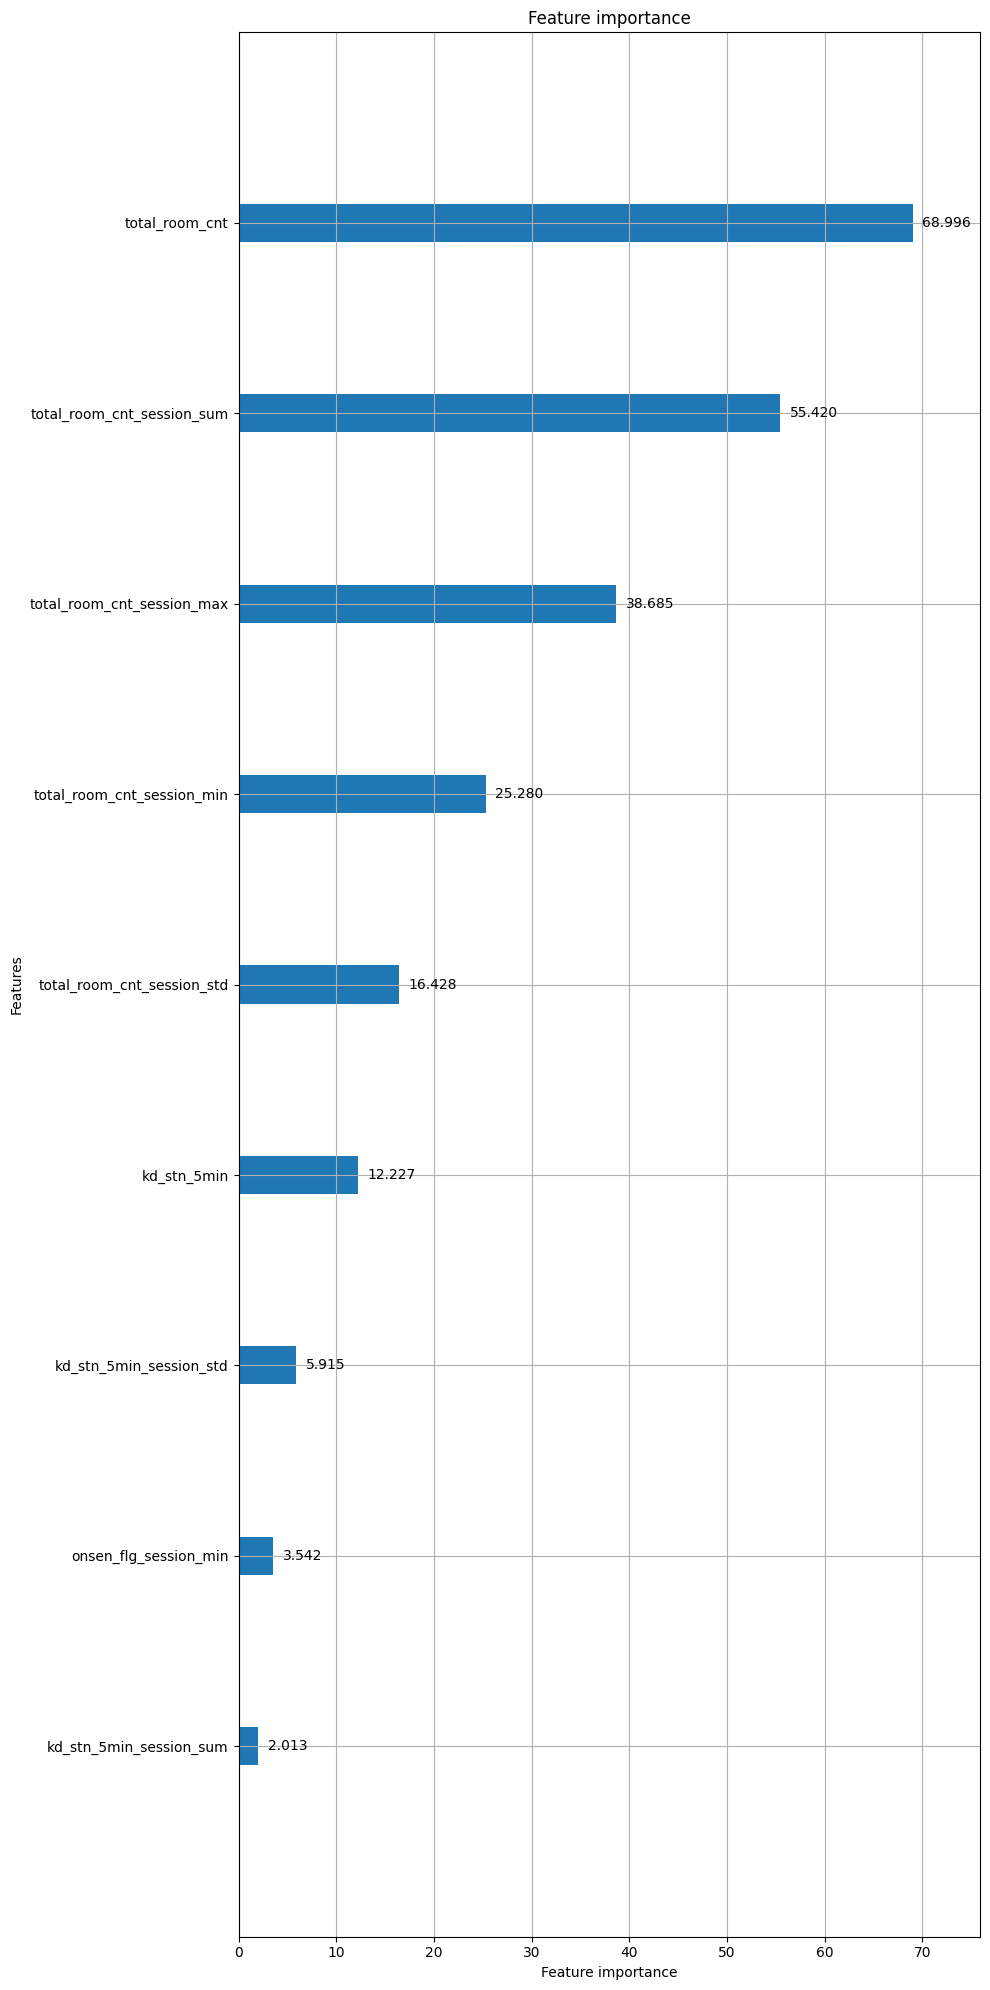

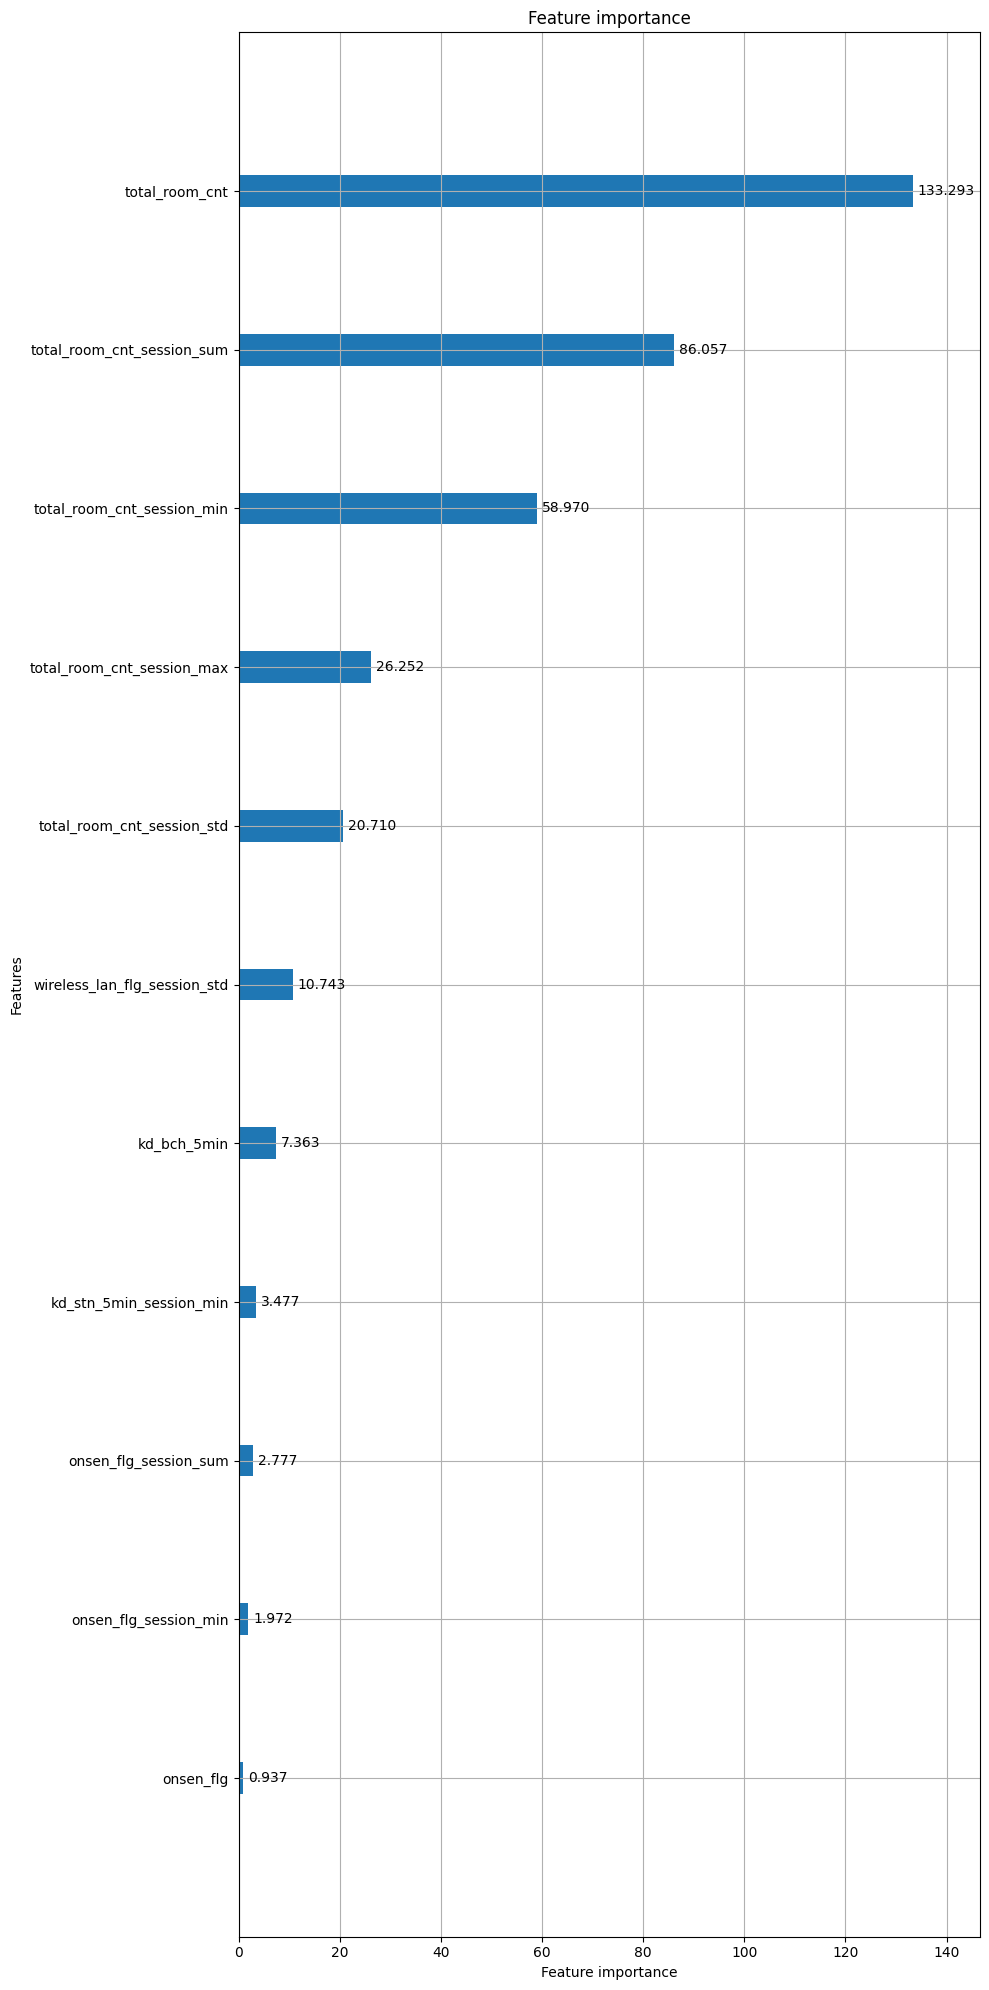

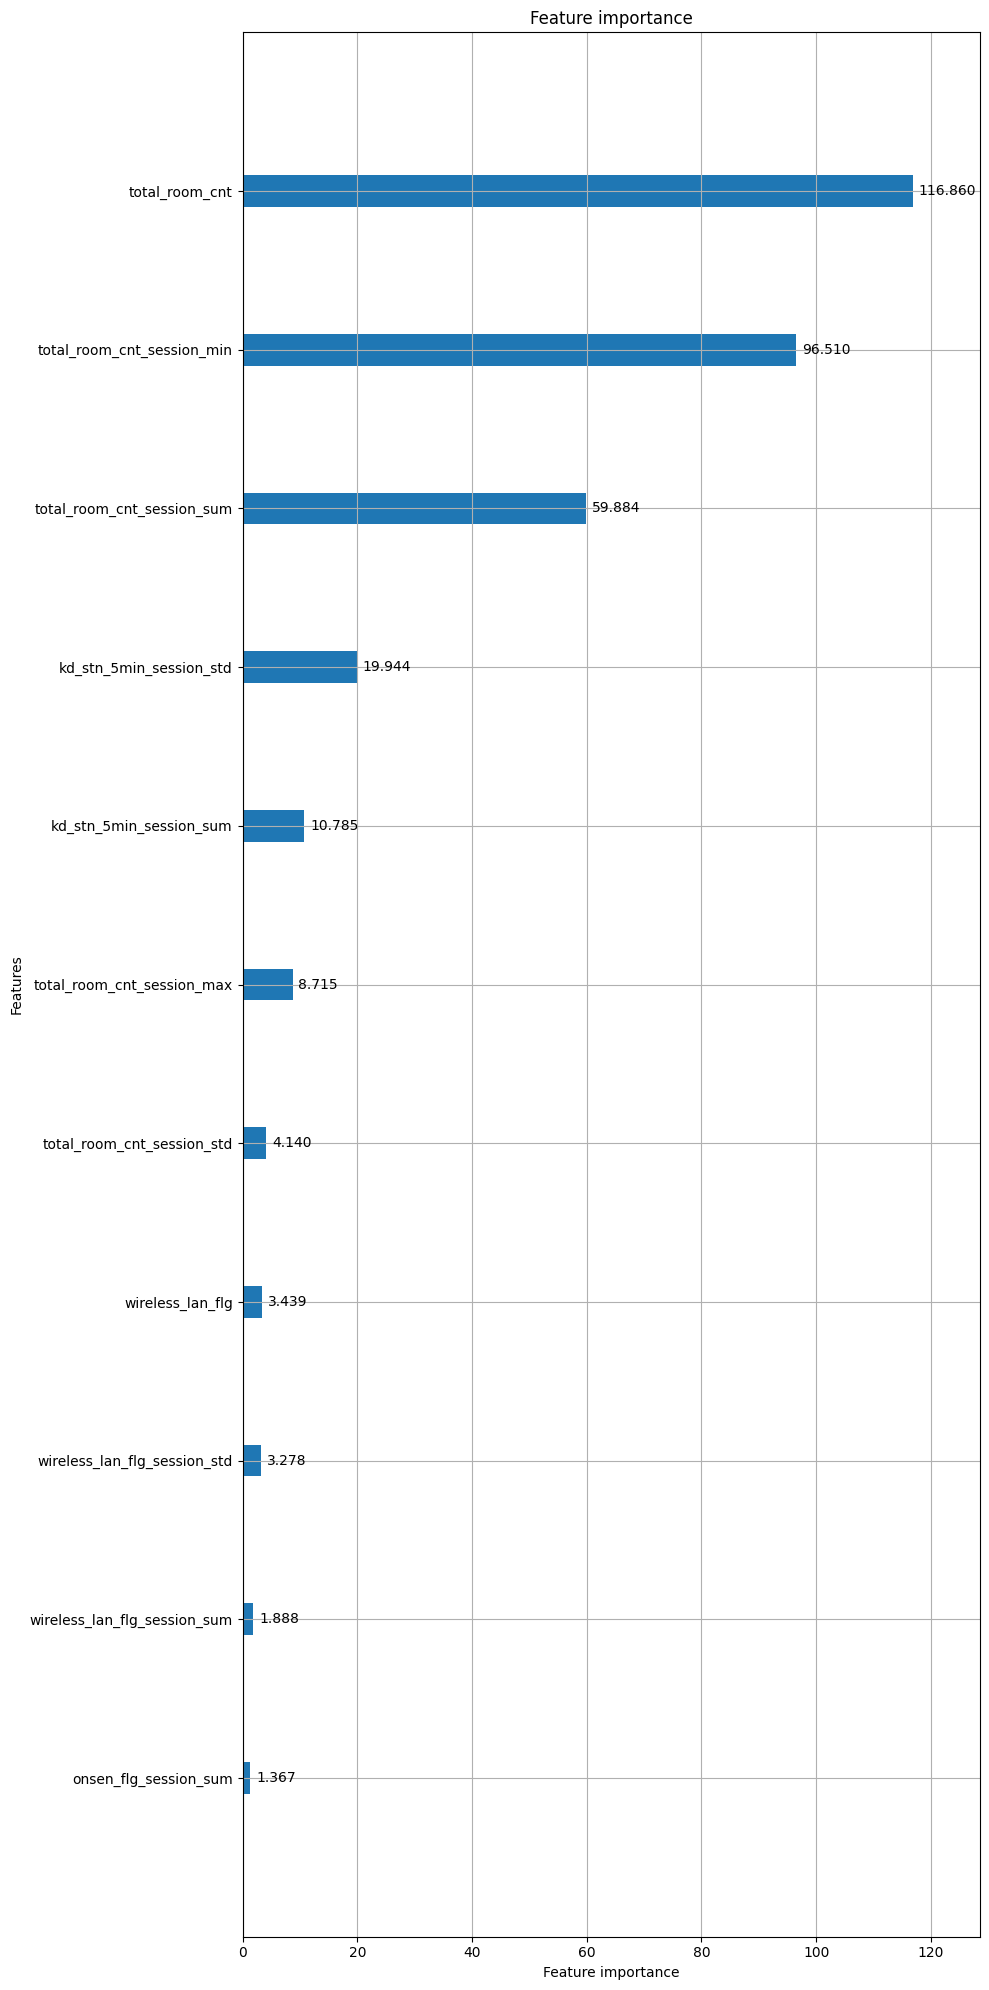

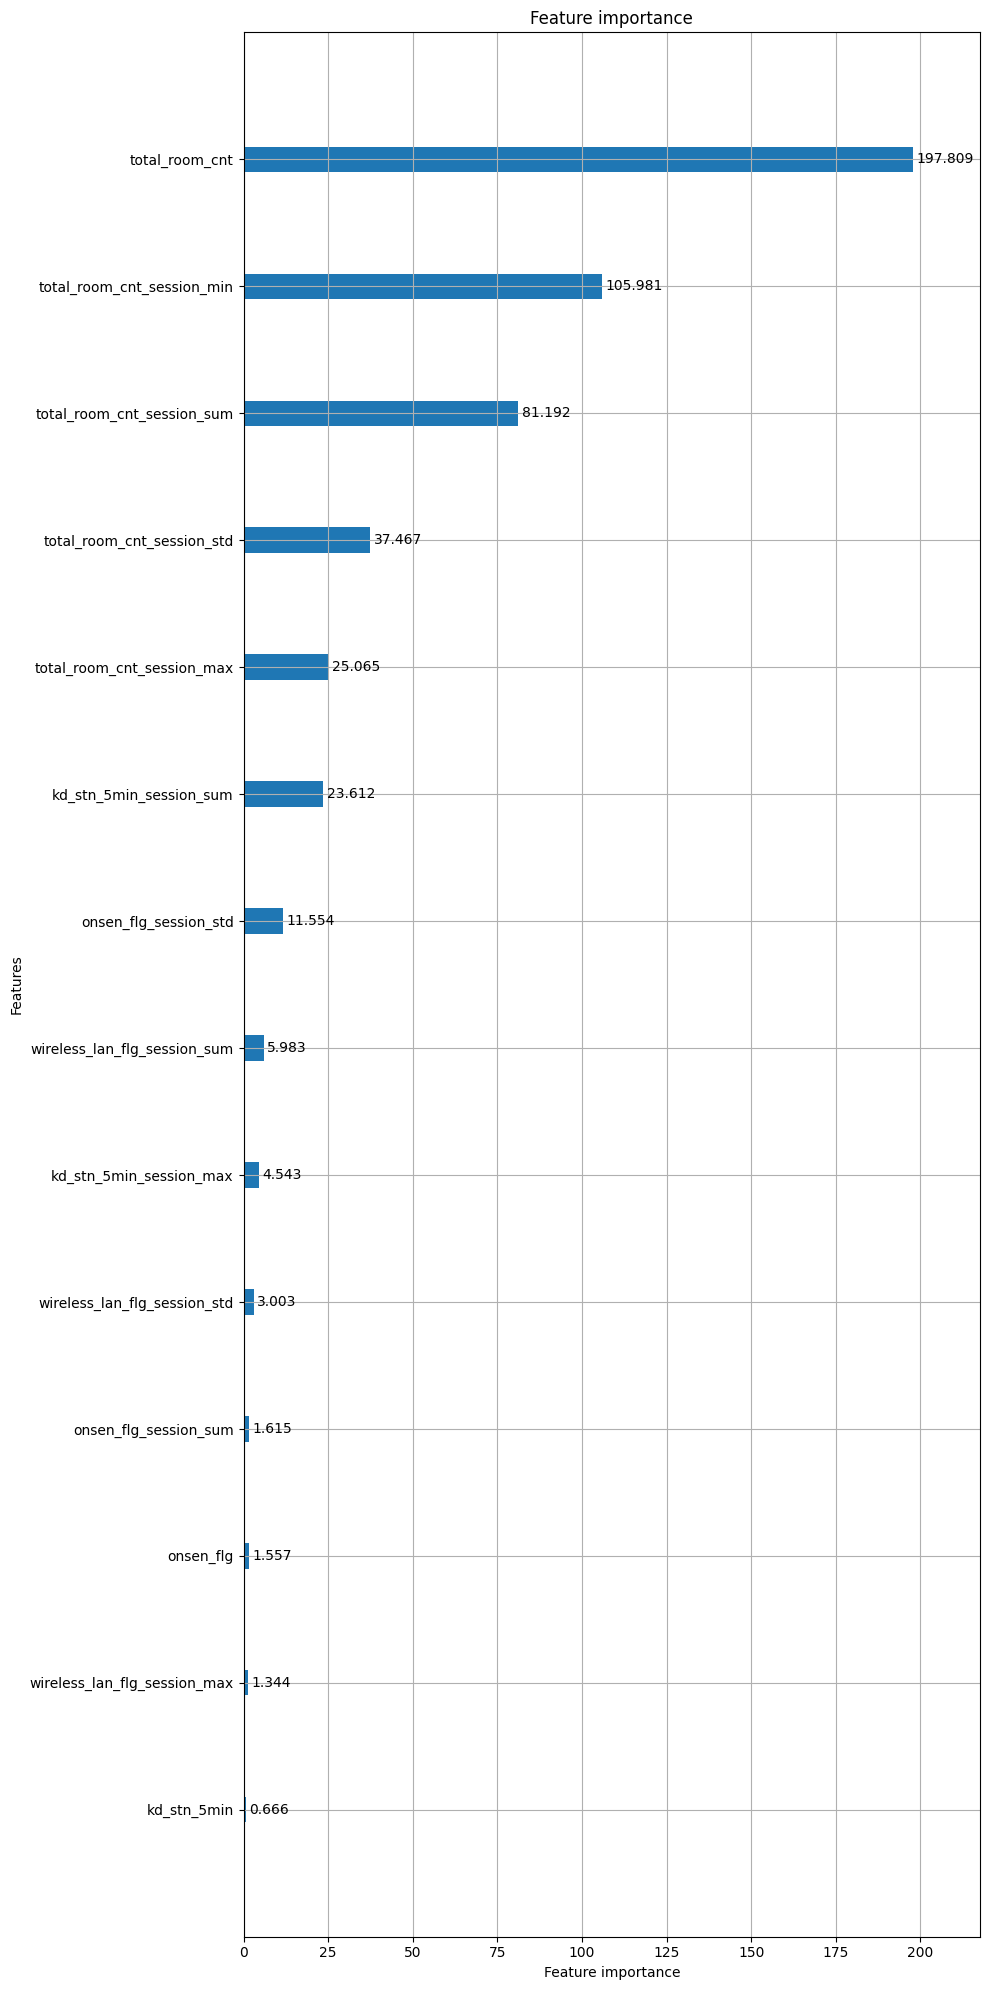

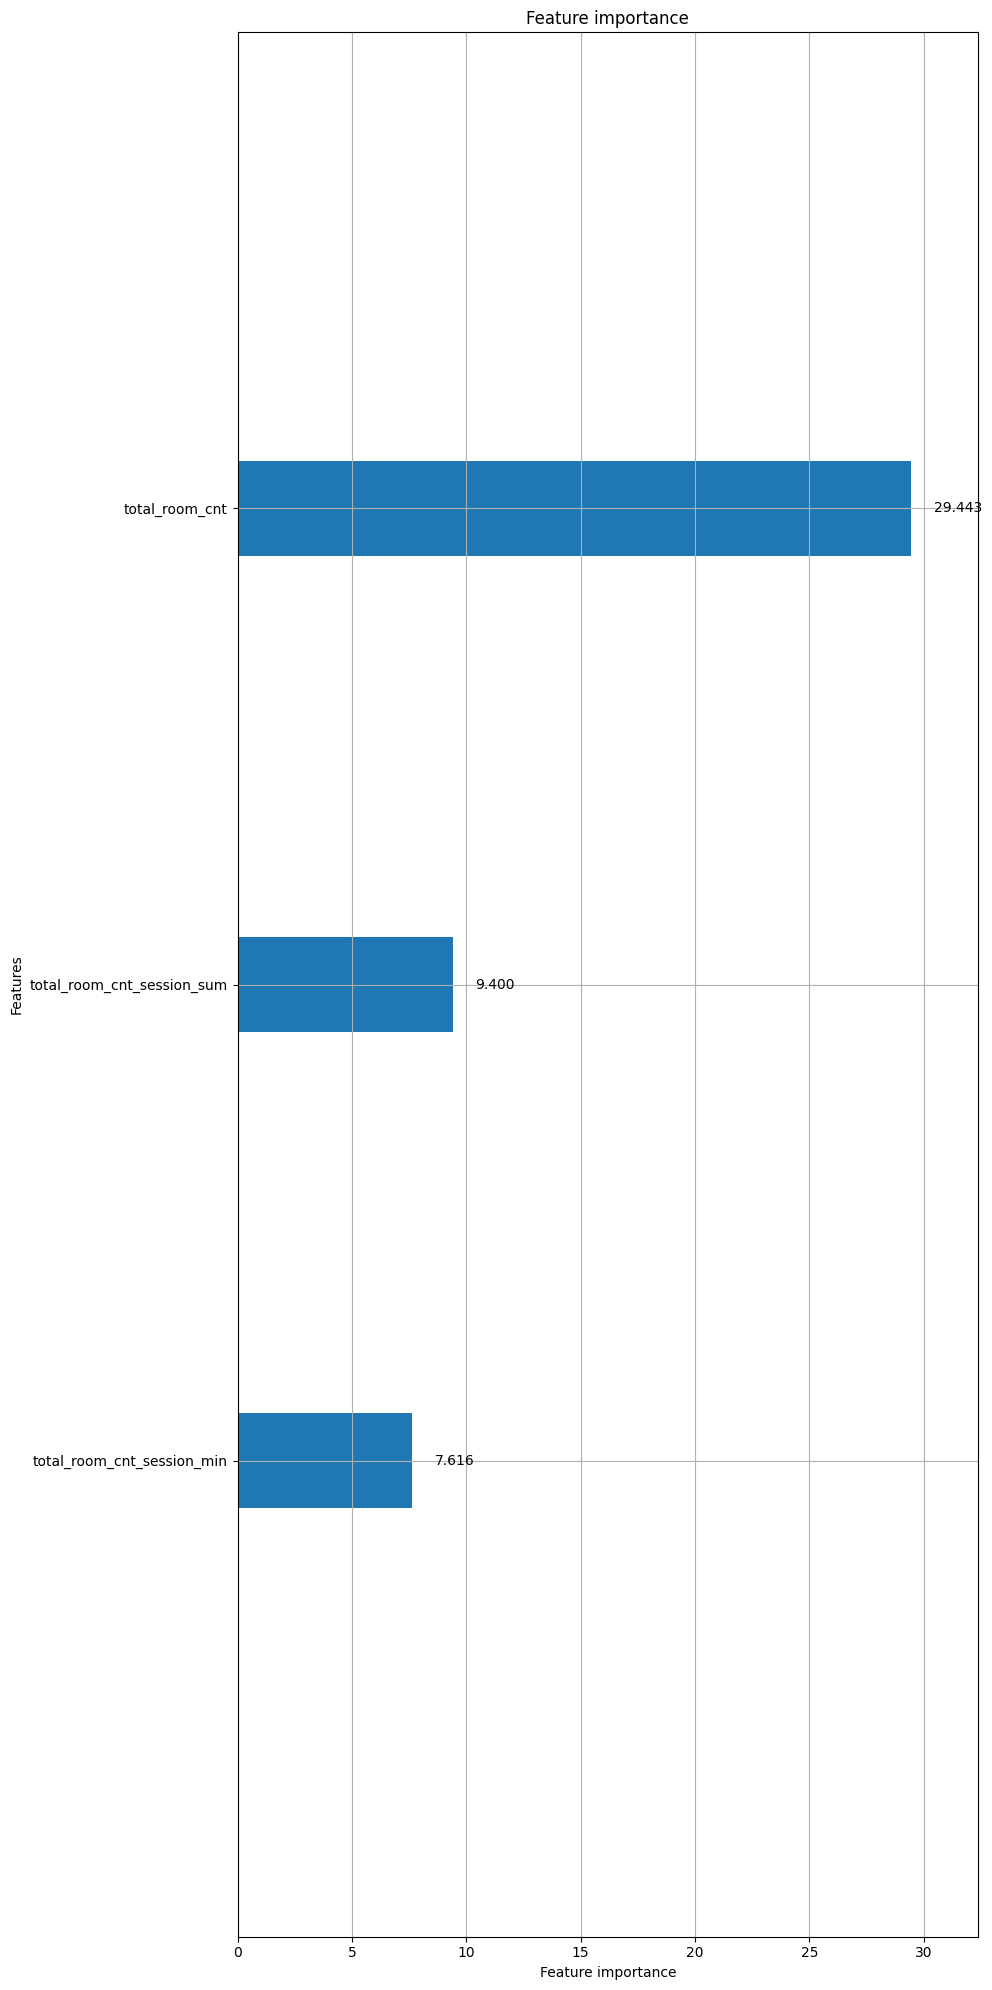

In [8]:
oof = np.zeros(len(train_df))
test_preds = np.zeros(len(test_df))
# train
for fold in range(num_folds):
    print(f"fold: {fold}")
    train_fold_df = train_df.filter(pl.col("fold") != fold)
    valid_fold_df = train_df.filter(pl.col("fold") == fold)

    print(f"train_fold_df: {train_fold_df.shape}")
    print(f"valid_fold_df: {valid_fold_df.shape}")

    bst = train_one_fold(cfg, train_fold_df, valid_fold_df)
    save_model(cfg, bst, output_path, fold)

    # valid
    y_valid_pred = predict_one_fold(cfg, bst, valid_fold_df)
    y_pred = predict_one_fold(cfg, bst, test_df)
    oof[index_array[train_df["fold"].to_numpy() == fold]] = y_valid_pred
    test_preds += y_pred / num_folds

    print()

    # (pl.col("original") == 1)  # originalのみで追加で付与したラベルは除外

In [76]:
from utils.metrics import calculate_metrics


# make submission
def make_submission(pred_df: pl.DataFrame, mode: str):
    session_df = load_session_data(Path(cfg.dir.data_dir), mode)
    pred_candidates_df = pred_df.group_by("session_id").agg(pl.col("candidates"))
    submission_df = (
        session_df.join(
            pred_candidates_df.with_columns(
                [
                    pl.col("candidates").list.get(i).alias(f"predict_{i}")
                    for i in range(10)
                ]
            ).drop("candidates"),
            on="session_id",
            how="left",
        )
        .fill_null(-1)
        .drop("session_id")
    )
    return submission_df, pred_candidates_df


oof_pred_df = (
    train_df.filter((pl.col("original") == 1))  # original以外の追加で付与したラベルは除外
    .select(
        ["session_id", "candidates"],
    )
    .with_columns(pl.Series(name="pred", values=oof))
    .sort(by=["session_id", "pred"], descending=True)
)
oof_submission_df, oof_candidaates_df = make_submission(oof_pred_df, "train")
train_label_df = load_label_data(Path(cfg.dir.data_dir))
candidaates_df = train_label_df.join(
    oof_candidaates_df, on="session_id", how="left"
).with_columns(pl.col("candidates").fill_null([]))

test_pred_df = (
    test_df.select(
        ["session_id", "candidates"],
    )
    .with_columns(pl.Series(name="pred", values=test_preds))
    .sort(by=["session_id", "pred"], descending=True)
)
test_submission_df, _ = make_submission(test_pred_df, "test")

In [77]:
calculate_metrics(candidaates_df, candidates_col="candidates", label_col="yad_no", k=10)

[{'k': 10,
  'avg_num_candidates': 0.003429188979487215,
  'recall': 4.156592702408746e-05,
  'precision': 4.156592702408745e-06,
  'map@k': 2.9793037971134115e-05}]